In [1]:
building_id = 2
price = 100
iteration = 0
# we are ready to run!

In [2]:
# Parameters
building_id = 3
price = 106
iteration = 6


In [3]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = 'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = 'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)



# Weather file
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = 'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [4]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
error_dir  = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(output_dir)

# EHUB
ehub_dir   = 'ehub/output_ehub_excel/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106
ga_file = ga_output_dir + "panel_{}_dual.xlsx".format(price)
ga_proc = ga_output_dir + "panel_{}_dual_processed.xlsx".format(price)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [7]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

## the North Axis
The north axis gets grabbed automatically from the idf.

In [8]:
pvbuilding.North_Axis

0.0

In [9]:
pvbuilding.Building_Information


Building,
    Ref Bldg Warehouse New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    40,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [10]:
# Determine the hourly electricity use
pvbuilding.run_ep()

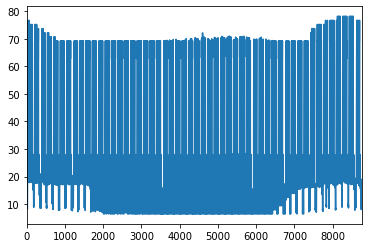

In [11]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [12]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 10,626.92
78.13965517958043


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [13]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 4,598 m²
Roof area is up 70 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [14]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 11.006727457046509 sec


0.0


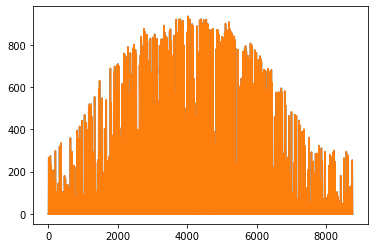

In [15]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)
Loading the model
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 400


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 30513.1


ERROR:ga_logger:total demand cost: 4667.576


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 261,136 kWh
At a cost of $ 0.0986 /kWh
Total Cost of the system: $ 30,513 per year


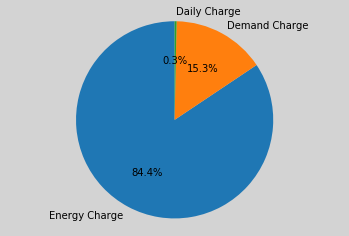

Total roof area of the  building: 4,598 m²
Total roof area used 0 m²
Percentage: 0.0%


In [16]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
if (number_of_panels==5):
    azi = [180,215,245,215,130]
    tilt = [35,55,10,35,5]
    gcr = [0.6,0.35,0.9,0.7,0.9]
# These are the fixed three panels that we are interested in
if (number_of_panels==3):
    azi = [180,215,245]
    tilt = [35,55,10]
    gcr = [0.9,0.35,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)

pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels)
my_model.eval_model(pan_vals,400,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [17]:
my_model.energyIm

261136.0

In [18]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    4667.576
dtype: float64

In [19]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         20723.9
Aug         22065.5
Dec         23271.5
Feb         20983.8
Jan         23774.3
Jul         19933.9
Jun         20611.8
Mar         23584.0
May         21175.7
Nov         22611.0
Oct         21919.2
Sep         20481.3
monthly_import    261135.9
dtype: float64
261136.0
     monthly_export
Apr             0.0
Aug             0.0
Dec             0.0
Feb             0.0
Jan             0.0
Jul             0.0
Jun             0.0
Mar             0.0
May             0.0
Nov             0.0
Oct             0.0
Sep             0.0
monthly_export    0.0
dtype: float64
0.0
97.5645


In [20]:
my_model.solveResults['solution']['daily_charge_c']

97.5645

In [21]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             0
PV0                  0
PV1                  0
PV2                  0

In [22]:
my_model.solveResults['solution']['any_above_35']

1

In [23]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [24]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (210, 180, 115, 31, 31, 21, 0.25, 0.6499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 21.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.996811151504517 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23783.2


ERROR:ga_logger:total demand cost: 4464.771


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,386 kWh
At a cost of $ 0.0738 /kWh
Total Cost of the system: $ 23,783 per year


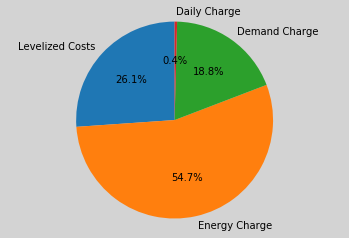

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (140, 110, 125, 31, 26, 21, 0.3, 0.8999999999999999, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23899.4


ERROR:ga_logger:total demand cost: 4465.540999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,236 kWh
At a cost of $ 0.0771 /kWh
Total Cost of the system: $ 23,899 per year


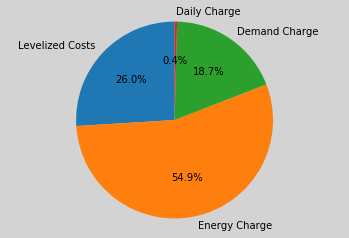

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (120, 180, 195, 51, 56, 21, 0.44999999999999996, 0.8999999999999999, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 51.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23923.9


ERROR:ga_logger:total demand cost: 4462.729


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,233 kWh
At a cost of $ 0.0755 /kWh
Total Cost of the system: $ 23,924 per year


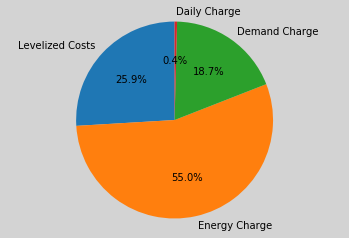

Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 255, 240, 11, 11, 16, 0.7999999999999998, 0.7999999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 11.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 16.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24770.6


ERROR:ga_logger:total demand cost: 4456.315


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 180,126 kWh
At a cost of $ 0.0778 /kWh
Total Cost of the system: $ 24,771 per year


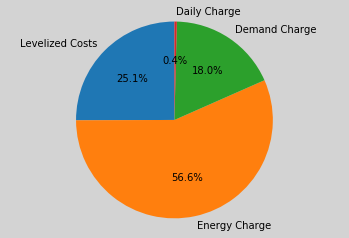

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 130, 105, 11, 56, 46, 0.44999999999999996, 0.35, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 11.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 56.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24232.2


ERROR:ga_logger:total demand cost: 4452.616


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,209 kWh
At a cost of $ 0.0778 /kWh
Total Cost of the system: $ 24,232 per year


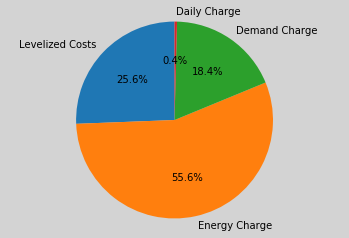

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (155, 175, 150, 21, 51, 46, 0.8499999999999999, 0.44999999999999996, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 51.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.863483667373657 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24123.4


ERROR:ga_logger:total demand cost: 4484.028


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,926 kWh
At a cost of $ 0.0776 /kWh
Total Cost of the system: $ 24,123 per year


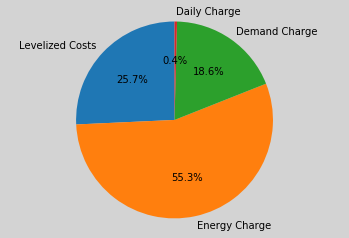

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (240, 255, 215, 51, 56, 41, 0.7, 0.39999999999999997, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24250.5


ERROR:ga_logger:total demand cost: 4480.033


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 180,294 kWh
At a cost of $ 0.0747 /kWh
Total Cost of the system: $ 24,250 per year


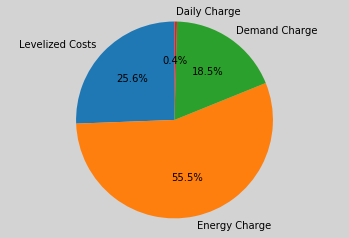

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (130, 235, 170, 36, 46, 21, 0.7499999999999998, 0.39999999999999997, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24467.6


ERROR:ga_logger:total demand cost: 4472.539


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,495 kWh
At a cost of $ 0.0776 /kWh
Total Cost of the system: $ 24,468 per year


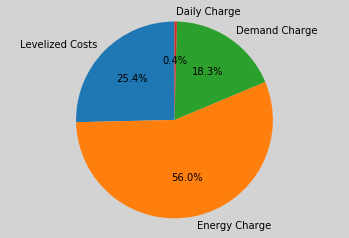

Total roof area of the  building: 4,598 m²
Total roof area used 735 m²
Percentage: 16.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 140, 195, 26, 51, 56, 0.3, 0.5499999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23527.1


ERROR:ga_logger:total demand cost: 4461.16


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,561 kWh
At a cost of $ 0.0748 /kWh
Total Cost of the system: $ 23,527 per year


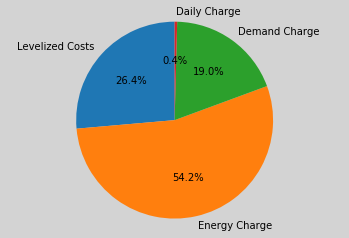

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (235, 180, 170, 51, 41, 56, 0.7499999999999998, 0.3, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 56.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 23527.2


ERROR:ga_logger:total demand cost: 4476.312


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,992 kWh
At a cost of $ 0.0741 /kWh
Total Cost of the system: $ 23,527 per year


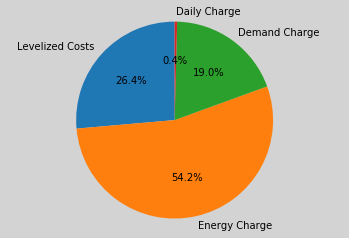

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (140, 250, 255, 46, 56, 46, 0.25, 0.7499999999999998, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24192.7


ERROR:ga_logger:total demand cost: 4480.209


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,862 kWh
At a cost of $ 0.0780 /kWh
Total Cost of the system: $ 24,193 per year


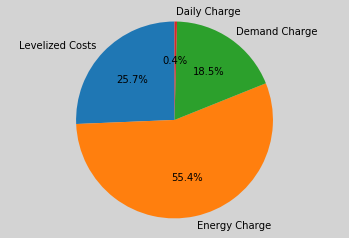

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 220, 265, 6, 11, 36, 0.44999999999999996, 0.35, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24503.4


ERROR:ga_logger:total demand cost: 4452.235


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 179,903 kWh
At a cost of $ 0.0764 /kWh
Total Cost of the system: $ 24,503 per year


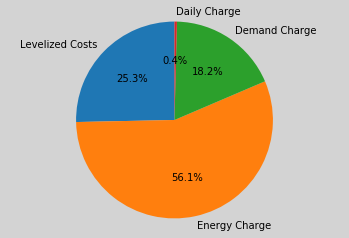

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 235, 210, 51, 36, 56, 0.25, 0.7499999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24171.7


ERROR:ga_logger:total demand cost: 4486.3009999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,941 kWh
At a cost of $ 0.0778 /kWh
Total Cost of the system: $ 24,172 per year


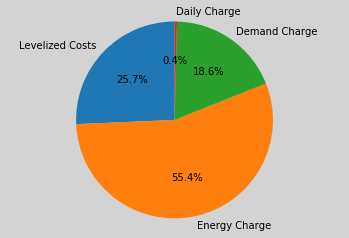

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (230, 110, 175, 26, 21, 46, 0.35, 0.49999999999999994, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23643.9


ERROR:ga_logger:total demand cost: 4480.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,697 kWh
At a cost of $ 0.0749 /kWh
Total Cost of the system: $ 23,644 per year


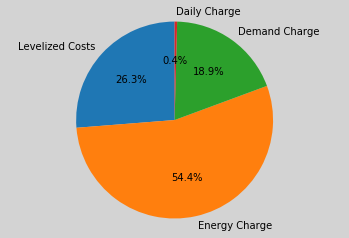

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (130, 240, 195, 41, 36, 16, 0.5499999999999999, 0.3, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 41.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 36.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.526901960372925 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23974.8


ERROR:ga_logger:total demand cost: 4455.151


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,832 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 23,975 per year


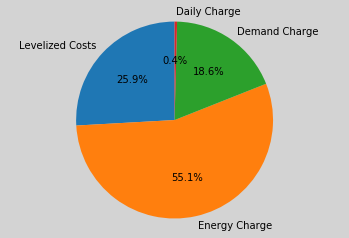

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (125, 240, 140, 51, 26, 46, 0.8499999999999999, 0.8999999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24514.1


ERROR:ga_logger:total demand cost: 4486.031


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,017 kWh
At a cost of $ 0.0789 /kWh
Total Cost of the system: $ 24,514 per year


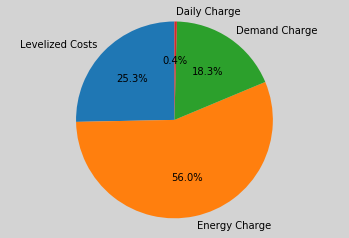

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 195, 165, 46, 21, 31, 0.7, 0.8499999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.240675926208496 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23516.2


ERROR:ga_logger:total demand cost: 4466.807


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,380 kWh
At a cost of $ 0.0748 /kWh
Total Cost of the system: $ 23,516 per year


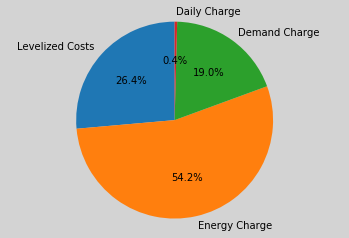

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 265, 265, 11, 56, 16, 0.6499999999999999, 0.7499999999999998, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 11.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.197343826293945 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 25048.4


ERROR:ga_logger:total demand cost: 4454.327


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 180,367 kWh
At a cost of $ 0.0792 /kWh
Total Cost of the system: $ 25,048 per year


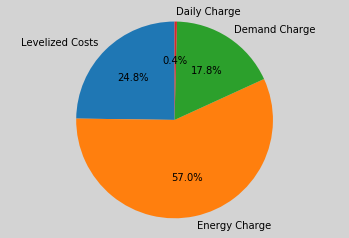

Total roof area of the  building: 4,598 m²
Total roof area used 962 m²
Percentage: 20.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (95, 100, 105, 51, 41, 6, 0.7, 0.35, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 51.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 25204.2


ERROR:ga_logger:total demand cost: 4453.927000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 177,504 kWh
At a cost of $ 0.0814 /kWh
Total Cost of the system: $ 25,204 per year


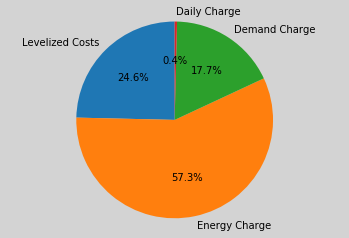

Total roof area of the  building: 4,598 m²
Total roof area used 694 m²
Percentage: 15.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (225, 220, 145, 11, 26, 16, 0.49999999999999994, 0.8499999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24091.9


ERROR:ga_logger:total demand cost: 4454.602


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,664 kWh
At a cost of $ 0.0777 /kWh
Total Cost of the system: $ 24,092 per year


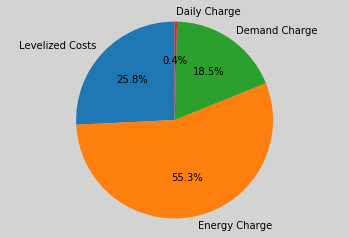

ERROR:optimizer_logger:20


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (175, 255, 155, 41, 26, 31, 0.7999999999999998, 0.7499999999999998, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23644.7


ERROR:ga_logger:total demand cost: 4466.767


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 169,975 kWh
At a cost of $ 0.0757 /kWh
Total Cost of the system: $ 23,645 per year


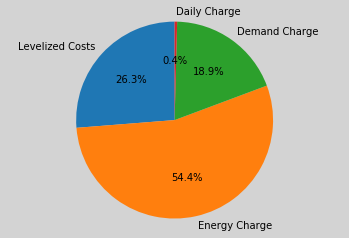

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (100, 230, 265, 26, 11, 56, 0.3, 0.7499999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24797.8


ERROR:ga_logger:total demand cost: 4455.830000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 178,436 kWh
At a cost of $ 0.0787 /kWh
Total Cost of the system: $ 24,798 per year


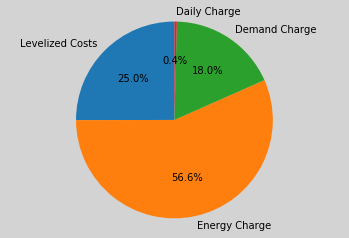

Total roof area of the  building: 4,598 m²
Total roof area used 833 m²
Percentage: 18.1%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 195, 240, 21, 41, 36, 0.44999999999999996, 0.8999999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23745.0


ERROR:ga_logger:total demand cost: 4459.549999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,210 kWh
At a cost of $ 0.0749 /kWh
Total Cost of the system: $ 23,745 per year


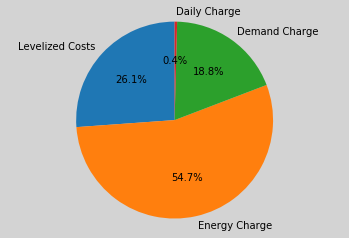

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (100, 255, 135, 46, 41, 46, 0.7999999999999998, 0.5999999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 25151.0


ERROR:ga_logger:total demand cost: 4492.88


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 177,901 kWh
At a cost of $ 0.0807 /kWh
Total Cost of the system: $ 25,151 per year


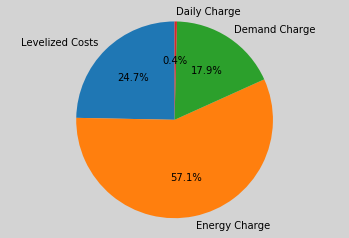

Total roof area of the  building: 4,598 m²
Total roof area used 1,136 m²
Percentage: 24.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (210, 230, 185, 51, 11, 1, 0.35, 0.5999999999999999, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 1.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24484.8


ERROR:ga_logger:total demand cost: 4490.8769999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 181,273 kWh
At a cost of $ 0.0755 /kWh
Total Cost of the system: $ 24,485 per year


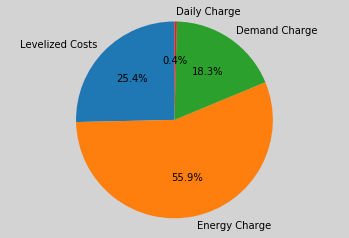

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (160, 215, 260, 6, 56, 1, 0.2, 0.49999999999999994, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 6.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 1.0
                                           and a gcr of 0.750


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 10.62395715713501 sec


ERROR:ga_logger:Generated the panel irradiance in  11s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24605.8


ERROR:ga_logger:total demand cost: 4450.351999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,857 kWh
At a cost of $ 0.0792 /kWh
Total Cost of the system: $ 24,606 per year


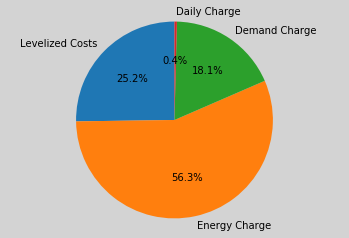

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (265, 205, 115, 16, 26, 46, 0.2, 0.5999999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24044.5


ERROR:ga_logger:total demand cost: 4468.566


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,229 kWh
At a cost of $ 0.0753 /kWh
Total Cost of the system: $ 24,044 per year


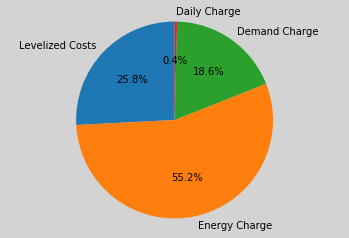

Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 180, 160, 51, 46, 46, 0.25, 0.7, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 51.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23873.0


ERROR:ga_logger:total demand cost: 4486.487999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,224 kWh
At a cost of $ 0.0755 /kWh
Total Cost of the system: $ 23,873 per year


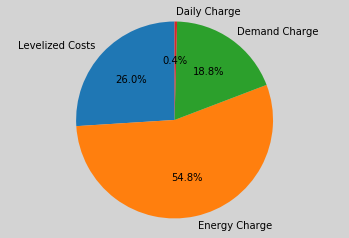

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (245, 135, 130, 6, 41, 1, 0.8999999999999999, 0.5999999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 41.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 25043.7


ERROR:ga_logger:total demand cost: 4488.325


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 177,607 kWh
At a cost of $ 0.0802 /kWh
Total Cost of the system: $ 25,044 per year


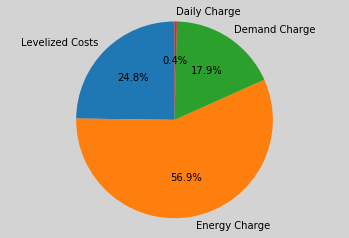

Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (185, 190, 140, 56, 1, 6, 0.3, 0.5499999999999999, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24231.0


ERROR:ga_logger:total demand cost: 4495.1


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 178,142 kWh
At a cost of $ 0.0754 /kWh
Total Cost of the system: $ 24,231 per year


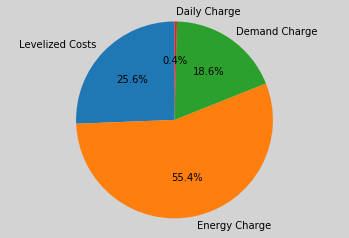

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (135, 215, 160, 11, 16, 26, 0.7, 0.8999999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24604.4


ERROR:ga_logger:total demand cost: 4454.834


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,348 kWh
At a cost of $ 0.0794 /kWh
Total Cost of the system: $ 24,604 per year


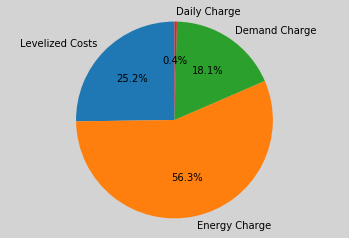

Total roof area of the  building: 4,598 m²
Total roof area used 893 m²
Percentage: 19.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (145, 265, 180, 56, 46, 36, 0.7999999999999998, 0.7999999999999998, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23767.2


ERROR:ga_logger:total demand cost: 4479.378


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,636 kWh
At a cost of $ 0.0748 /kWh
Total Cost of the system: $ 23,767 per year


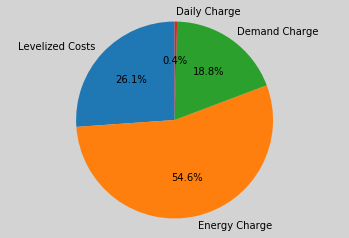

Total roof area of the  building: 4,598 m²
Total roof area used 1,136 m²
Percentage: 24.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (210, 215, 165, 46, 56, 1, 0.3, 0.25, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 210
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 56.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 1.0
                                           and a gcr of 0.300


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.312225341796875 sec


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24143.4


ERROR:ga_logger:total demand cost: 4482.446000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 179,384 kWh
At a cost of $ 0.0745 /kWh
Total Cost of the system: $ 24,143 per year


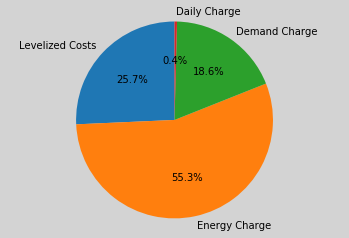

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 155, 230, 46, 16, 46, 0.5499999999999999, 0.7999999999999998, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 16.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 46.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24472.9


ERROR:ga_logger:total demand cost: 4463.005


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,110 kWh
At a cost of $ 0.0783 /kWh
Total Cost of the system: $ 24,473 per year


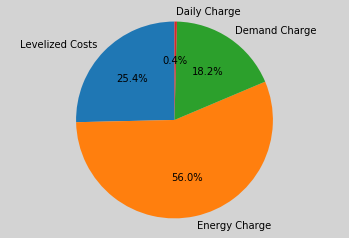

Total roof area of the  building: 4,598 m²
Total roof area used 781 m²
Percentage: 17.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (115, 110, 215, 1, 51, 6, 0.39999999999999997, 0.39999999999999997, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 1.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24731.6


ERROR:ga_logger:total demand cost: 4450.467000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,855 kWh
At a cost of $ 0.0790 /kWh
Total Cost of the system: $ 24,732 per year


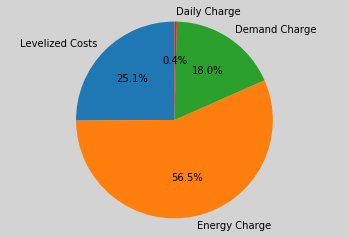

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (105, 240, 125, 6, 56, 36, 0.3, 0.3, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24325.9


ERROR:ga_logger:total demand cost: 4467.972


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,263 kWh
At a cost of $ 0.0787 /kWh
Total Cost of the system: $ 24,326 per year


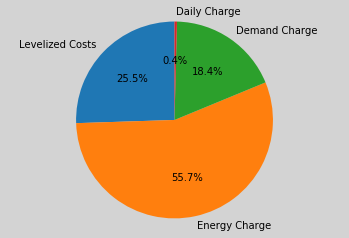

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (130, 125, 190, 1, 31, 56, 0.6499999999999999, 0.35, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24173.5


ERROR:ga_logger:total demand cost: 4490.724


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,160 kWh
At a cost of $ 0.0759 /kWh
Total Cost of the system: $ 24,174 per year


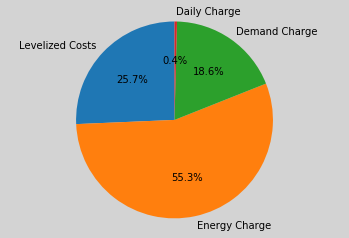

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 135, 165, 21, 6, 36, 0.2, 0.49999999999999994, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23782.5


ERROR:ga_logger:total demand cost: 4456.231


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,186 kWh
At a cost of $ 0.0765 /kWh
Total Cost of the system: $ 23,782 per year


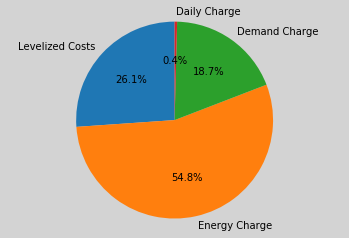

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 260, 150, 46, 11, 21, 0.8499999999999999, 0.5499999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 46.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.65399432182312 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23782.5


ERROR:ga_logger:total demand cost: 4456.231


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,421 kWh
At a cost of $ 0.0764 /kWh
Total Cost of the system: $ 23,782 per year


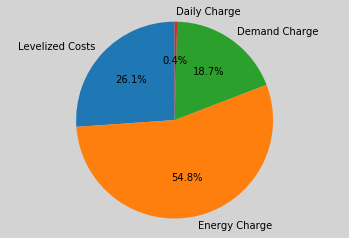

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (220, 225, 105, 6, 41, 21, 0.5999999999999999, 0.39999999999999997, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 6.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24618.3


ERROR:ga_logger:total demand cost: 4480.078


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 182,989 kWh
At a cost of $ 0.0756 /kWh
Total Cost of the system: $ 24,618 per year


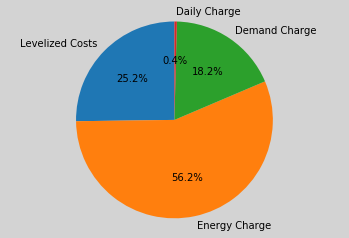

ERROR:optimizer_logger:40


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (235, 100, 165, 21, 1, 16, 0.7, 0.7499999999999998, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 1.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23901.6


ERROR:ga_logger:total demand cost: 4454.2570000000005


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,716 kWh
At a cost of $ 0.0765 /kWh
Total Cost of the system: $ 23,902 per year


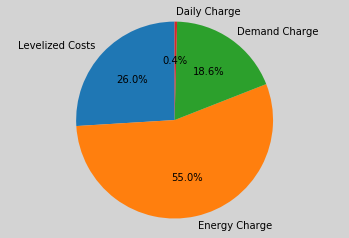

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (145, 110, 260, 46, 1, 51, 0.44999999999999996, 0.6499999999999999, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24490.3


ERROR:ga_logger:total demand cost: 4488.227


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,038 kWh
At a cost of $ 0.0787 /kWh
Total Cost of the system: $ 24,490 per year


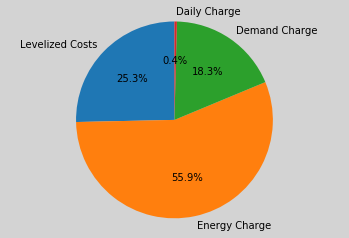

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (225, 250, 240, 31, 1, 16, 0.25, 0.6499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 225
                                           a tilt of 31.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.8612024784088135 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 1.0
                                           and a gcr of 0.650


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 12.297427654266357 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in  21s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24202.1


ERROR:ga_logger:total demand cost: 4464.826


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 179,857 kWh
At a cost of $ 0.0747 /kWh
Total Cost of the system: $ 24,202 per year


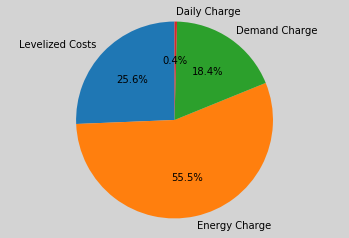

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 155, 180, 51, 31, 1, 0.39999999999999997, 0.44999999999999996, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 23778.8


ERROR:ga_logger:total demand cost: 4469.484


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,019 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 23,779 per year


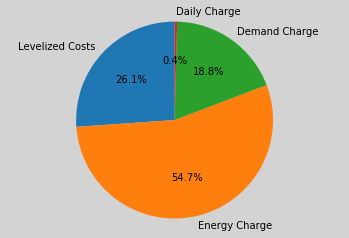

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (120, 150, 260, 31, 31, 36, 0.8499999999999999, 0.5999999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 31.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24186.5


ERROR:ga_logger:total demand cost: 4474.707


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,853 kWh
At a cost of $ 0.0771 /kWh
Total Cost of the system: $ 24,186 per year


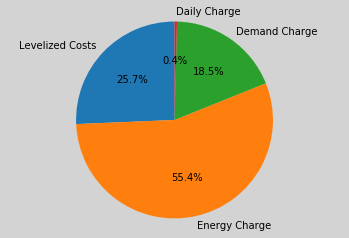

Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 230, 250, 26, 31, 41, 0.5499999999999999, 0.7, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 26.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 31.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 41.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.847464561462402 sec


ERROR:ga_logger:Generated the panel irradiance in   9s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24017.3


ERROR:ga_logger:total demand cost: 4466.780000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,310 kWh
At a cost of $ 0.0769 /kWh
Total Cost of the system: $ 24,017 per year


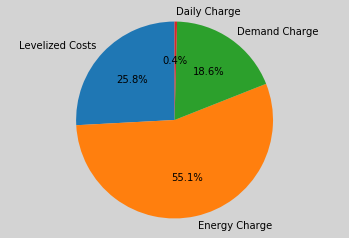

Total roof area of the  building: 4,598 m²
Total roof area used 1,136 m²
Percentage: 24.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (240, 100, 245, 1, 41, 51, 0.49999999999999994, 0.25, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 1.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 41.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.048872470855713 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 25125.2


ERROR:ga_logger:total demand cost: 4449.934


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 178,131 kWh
At a cost of $ 0.0807 /kWh
Total Cost of the system: $ 25,125 per year


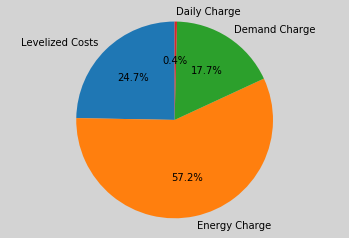

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (110, 135, 205, 51, 46, 16, 0.35, 0.49999999999999994, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 16.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24289.9


ERROR:ga_logger:total demand cost: 4459.872


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,816 kWh
At a cost of $ 0.0769 /kWh
Total Cost of the system: $ 24,290 per year


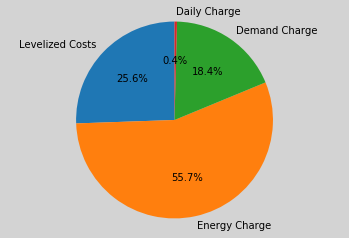

Total roof area of the  building: 4,598 m²
Total roof area used 893 m²
Percentage: 19.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 170, 175, 46, 11, 21, 0.3, 0.7, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 46.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 11.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23660.6


ERROR:ga_logger:total demand cost: 4458.003000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,864 kWh
At a cost of $ 0.0738 /kWh
Total Cost of the system: $ 23,661 per year


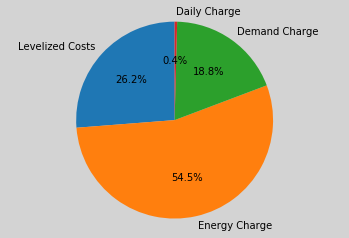

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (125, 200, 255, 51, 26, 36, 0.6499999999999999, 0.49999999999999994, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 23807.2


ERROR:ga_logger:total demand cost: 4465.548000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,763 kWh
At a cost of $ 0.0746 /kWh
Total Cost of the system: $ 23,807 per year


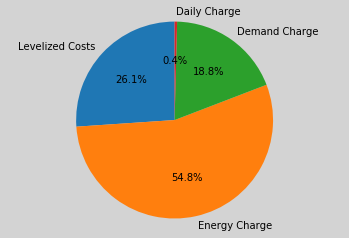

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 250, 150, 56, 16, 41, 0.39999999999999997, 0.8499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 16.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24420.4


ERROR:ga_logger:total demand cost: 4499.72


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,016 kWh
At a cost of $ 0.0774 /kWh
Total Cost of the system: $ 24,420 per year


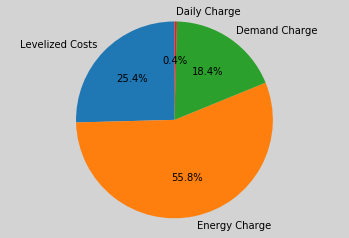

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 185, 150, 36, 51, 31, 0.44999999999999996, 0.3, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23600.2


ERROR:ga_logger:total demand cost: 4475.493


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,411 kWh
At a cost of $ 0.0744 /kWh
Total Cost of the system: $ 23,600 per year


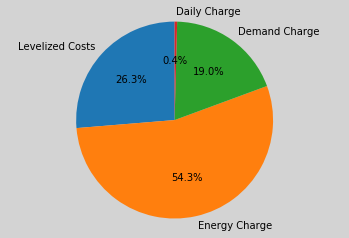

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (145, 250, 150, 46, 11, 11, 0.5999999999999999, 0.39999999999999997, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 11.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24280.2


ERROR:ga_logger:total demand cost: 4451.588


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,918 kWh
At a cost of $ 0.0782 /kWh
Total Cost of the system: $ 24,280 per year


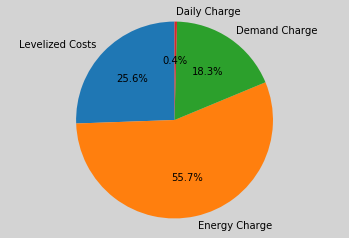

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (185, 215, 190, 16, 21, 36, 0.2, 0.35, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.350


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.785090208053589 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23471.7


ERROR:ga_logger:total demand cost: 4470.813


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,836 kWh
At a cost of $ 0.0735 /kWh
Total Cost of the system: $ 23,472 per year


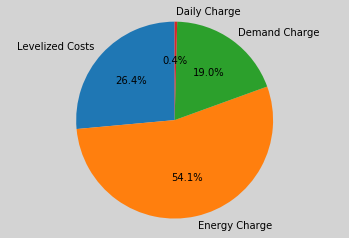

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 180, 265, 41, 6, 56, 0.25, 0.25, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 41.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23475.5


ERROR:ga_logger:total demand cost: 4474.722


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,652 kWh
At a cost of $ 0.0740 /kWh
Total Cost of the system: $ 23,476 per year


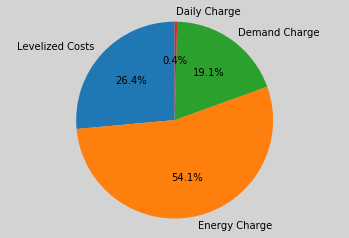

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (185, 205, 150, 36, 46, 56, 0.44999999999999996, 0.7, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 36.0
                                           and a gcr of 0.450


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.6208295822143555 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23578.8


ERROR:ga_logger:total demand cost: 4475.519


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,766 kWh
At a cost of $ 0.0741 /kWh
Total Cost of the system: $ 23,579 per year


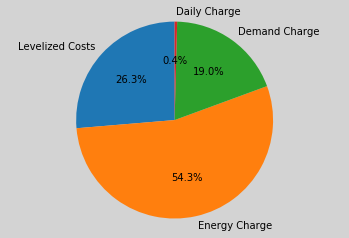

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (95, 260, 125, 21, 51, 31, 0.7999999999999998, 0.6499999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 21.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 51.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  98s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24433.5


ERROR:ga_logger:total demand cost: 4466.6720000000005


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,592 kWh
At a cost of $ 0.0792 /kWh
Total Cost of the system: $ 24,434 per year


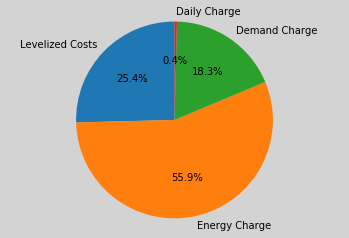

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (205, 215, 235, 36, 56, 21, 0.7499999999999998, 0.7999999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 56.0
                                           and a gcr of 0.800


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 12.051307439804077 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in  12s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24643.8


ERROR:ga_logger:total demand cost: 4460.578


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 180,632 kWh
At a cost of $ 0.0768 /kWh
Total Cost of the system: $ 24,644 per year


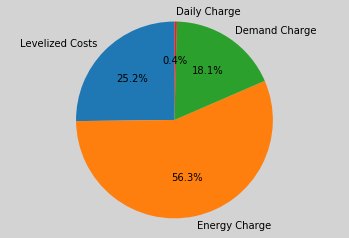

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (205, 160, 190, 26, 36, 46, 0.7999999999999998, 0.7499999999999998, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 26.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 46.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23635.5


ERROR:ga_logger:total demand cost: 4478.763


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,552 kWh
At a cost of $ 0.0741 /kWh
Total Cost of the system: $ 23,636 per year


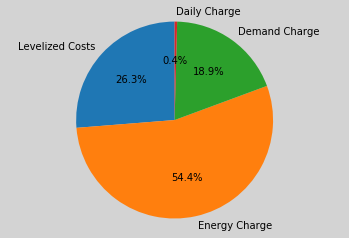

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 125, 160, 26, 51, 1, 0.3, 0.7499999999999998, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 1.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 25062.8


ERROR:ga_logger:total demand cost: 4461.4310000000005


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 184,461 kWh
At a cost of $ 0.0775 /kWh
Total Cost of the system: $ 25,063 per year


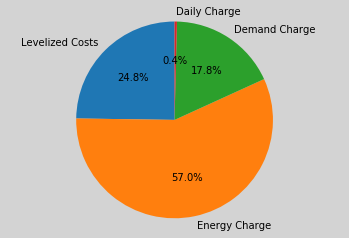

ERROR:optimizer_logger:60


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (130, 145, 150, 1, 21, 56, 0.3, 0.25, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 23876.6


ERROR:ga_logger:total demand cost: 4456.731


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,385 kWh
At a cost of $ 0.0770 /kWh
Total Cost of the system: $ 23,877 per year


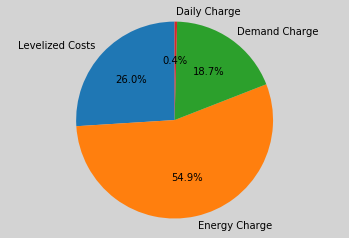

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 145, 185, 56, 6, 11, 0.39999999999999997, 0.8999999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 6.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 56s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24217.6


ERROR:ga_logger:total demand cost: 4452.399


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 207,333 kWh
At a cost of $ 0.0649 /kWh
Total Cost of the system: $ 24,218 per year


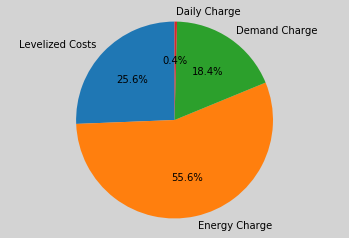

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 150, 110, 46, 6, 26, 0.5999999999999999, 0.8499999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 6.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 26.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 5.647221565246582 sec


ERROR:ga_logger:Generated the panel irradiance in   6s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24739.9


ERROR:ga_logger:total demand cost: 4459.491


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,713 kWh
At a cost of $ 0.0805 /kWh
Total Cost of the system: $ 24,740 per year


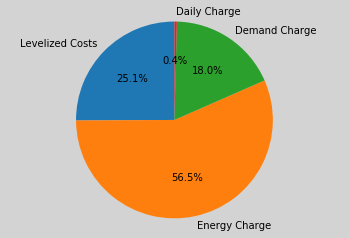

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (110, 165, 135, 1, 21, 56, 0.8499999999999999, 0.5499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 110
                                           a tilt of 1.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 56.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 23852.3


ERROR:ga_logger:total demand cost: 4461.43


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,078 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 23,852 per year


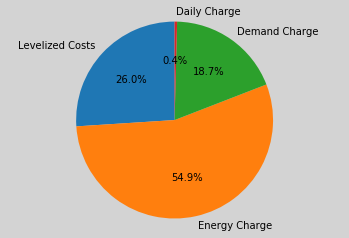

Total roof area of the  building: 4,598 m²
Total roof area used 1,136 m²
Percentage: 24.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (220, 110, 195, 36, 26, 16, 0.3, 0.39999999999999997, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23988.0


ERROR:ga_logger:total demand cost: 4455.652


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,953 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 23,988 per year


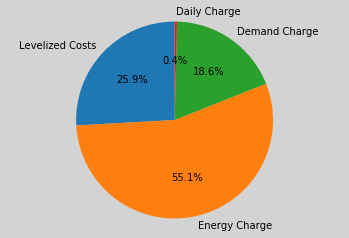

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (240, 200, 120, 11, 6, 41, 0.7499999999999998, 0.7, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 11.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 6.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24672.2


ERROR:ga_logger:total demand cost: 4451.472


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,219 kWh
At a cost of $ 0.0790 /kWh
Total Cost of the system: $ 24,672 per year


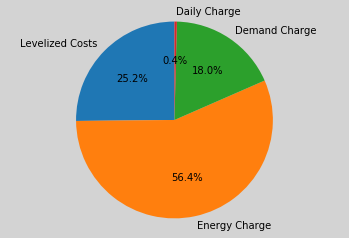

Total roof area of the  building: 4,598 m²
Total roof area used 893 m²
Percentage: 19.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (115, 175, 260, 46, 36, 41, 0.5499999999999999, 0.8499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 46.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 41.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24642.1


ERROR:ga_logger:total demand cost: 4494.946


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 178,588 kWh
At a cost of $ 0.0775 /kWh
Total Cost of the system: $ 24,642 per year


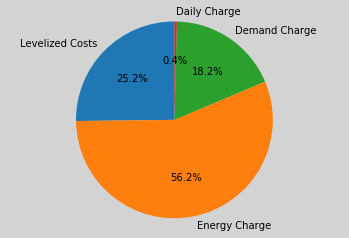

Total roof area of the  building: 4,598 m²
Total roof area used 735 m²
Percentage: 16.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (255, 185, 180, 26, 21, 26, 0.49999999999999994, 0.5499999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 53s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23490.6


ERROR:ga_logger:total demand cost: 4461.215


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,422 kWh
At a cost of $ 0.0742 /kWh
Total Cost of the system: $ 23,491 per year


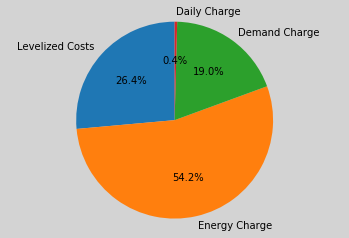

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 145, 155, 16, 41, 26, 0.35, 0.35, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23926.5


ERROR:ga_logger:total demand cost: 4454.7080000000005


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,369 kWh
At a cost of $ 0.0759 /kWh
Total Cost of the system: $ 23,926 per year


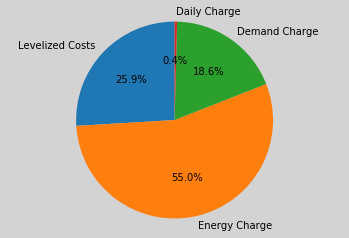

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (265, 190, 125, 26, 36, 1, 0.5999999999999999, 0.25, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 26.0
                                           and a gcr of 0.600


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 8.59230923652649 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.200


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 12.848423719406128 sec


ERROR:ga_logger:Generated the panel irradiance in  22s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 23439.3


ERROR:ga_logger:total demand cost: 4469.49


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 232,811 kWh
At a cost of $ 0.0544 /kWh
Total Cost of the system: $ 23,439 per year


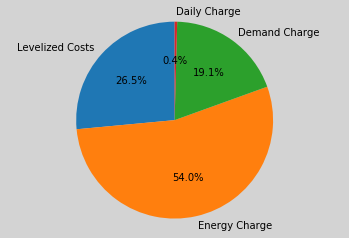

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (230, 195, 145, 11, 1, 46, 0.8999999999999999, 0.7999999999999998, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 11.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 1.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24490.3


ERROR:ga_logger:total demand cost: 4488.227


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,533 kWh
At a cost of $ 0.0785 /kWh
Total Cost of the system: $ 24,490 per year


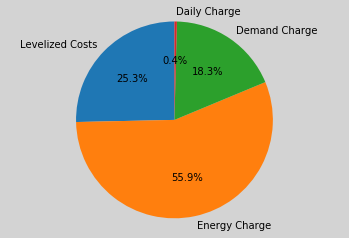

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (125, 205, 180, 6, 51, 51, 0.35, 0.49999999999999994, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 6.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 51.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24278.7


ERROR:ga_logger:total demand cost: 4497.668000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,928 kWh
At a cost of $ 0.0766 /kWh
Total Cost of the system: $ 24,279 per year


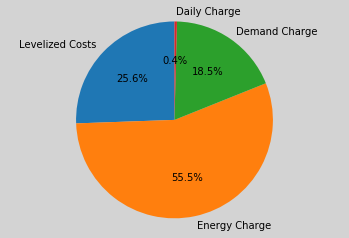

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (140, 175, 110, 21, 11, 51, 0.2, 0.8499999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 11.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23946.3


ERROR:ga_logger:total demand cost: 4456.207


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,423 kWh
At a cost of $ 0.0774 /kWh
Total Cost of the system: $ 23,946 per year


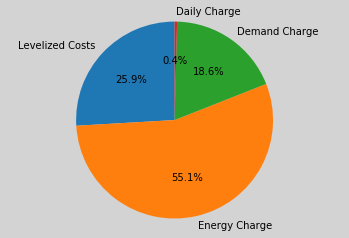

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (175, 240, 110, 1, 46, 26, 0.49999999999999994, 0.6499999999999999, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 1.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24882.2


ERROR:ga_logger:total demand cost: 4461.918


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,657 kWh
At a cost of $ 0.0808 /kWh
Total Cost of the system: $ 24,882 per year


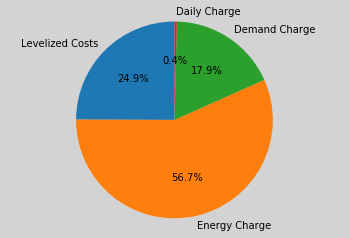

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (235, 195, 215, 46, 1, 16, 0.7499999999999998, 0.8499999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 46.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 1.0
                                           and a gcr of 0.850


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 6.334566354751587 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   7s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 64s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24210.7


ERROR:ga_logger:total demand cost: 4454.378


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,157 kWh
At a cost of $ 0.0764 /kWh
Total Cost of the system: $ 24,211 per year


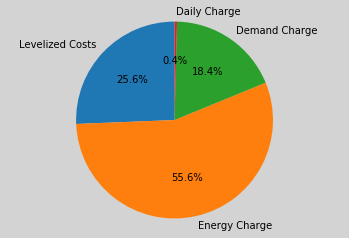

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (140, 110, 120, 31, 1, 56, 0.44999999999999996, 0.35, 0.7)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 1.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 56.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 60s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24117.5


ERROR:ga_logger:total demand cost: 4469.4310000000005


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,716 kWh
At a cost of $ 0.0777 /kWh
Total Cost of the system: $ 24,118 per year


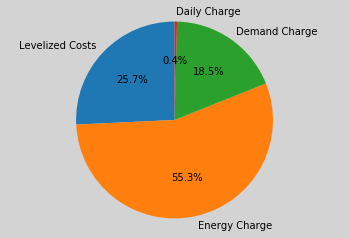

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 220, 130, 51, 6, 46, 0.3, 0.44999999999999996, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 6.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 46.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23974.2


ERROR:ga_logger:total demand cost: 4488.611


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,397 kWh
At a cost of $ 0.0751 /kWh
Total Cost of the system: $ 23,974 per year


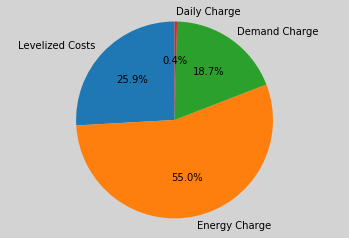

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (140, 100, 200, 21, 11, 21, 0.2, 0.49999999999999994, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 200
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23946.3


ERROR:ga_logger:total demand cost: 4456.207


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,592 kWh
At a cost of $ 0.0773 /kWh
Total Cost of the system: $ 23,946 per year


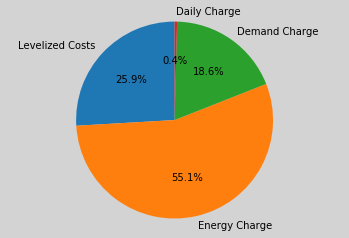

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 200, 115, 51, 11, 46, 0.8999999999999999, 0.25, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24286.5


ERROR:ga_logger:total demand cost: 4451.84


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,966 kWh
At a cost of $ 0.0773 /kWh
Total Cost of the system: $ 24,286 per year


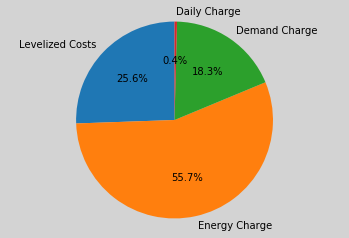

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (115, 160, 150, 6, 1, 1, 0.7999999999999998, 0.7999999999999998, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 1.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 1.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24979.3


ERROR:ga_logger:total demand cost: 4452.152


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,369 kWh
At a cost of $ 0.0806 /kWh
Total Cost of the system: $ 24,979 per year


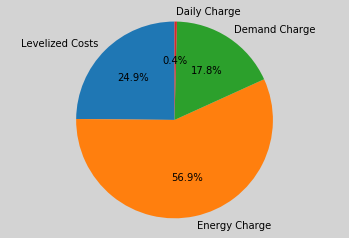

ERROR:optimizer_logger:80


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 4,598 m²
Total roof area used 781 m²
Percentage: 17.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (245, 230, 125, 1, 26, 26, 0.49999999999999994, 0.39999999999999997, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 1.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24434.9


ERROR:ga_logger:total demand cost: 4463.279


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 182,088 kWh
At a cost of $ 0.0751 /kWh
Total Cost of the system: $ 24,435 per year


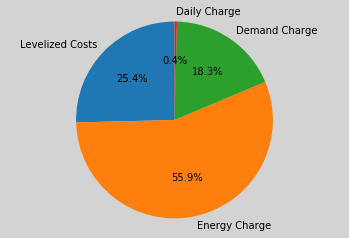

Total roof area of the  building: 4,598 m²
Total roof area used 1,562 m²
Percentage: 34.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (190, 200, 165, 56, 21, 11, 0.25, 0.49999999999999994, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 190
                                           a tilt of 56.0
                                           and a gcr of 0.250


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 9.698869943618774 sec


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in  10s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 59s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 23890.1


ERROR:ga_logger:total demand cost: 4460.490000000001


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,369 kWh
At a cost of $ 0.0748 /kWh
Total Cost of the system: $ 23,890 per year


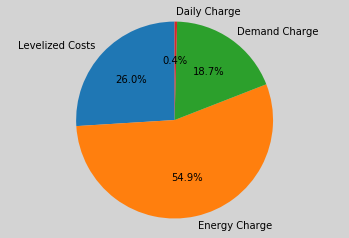

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (200, 215, 185, 41, 16, 46, 0.7999999999999998, 0.5499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 103s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23961.1


ERROR:ga_logger:total demand cost: 4490.749


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,503 kWh
At a cost of $ 0.0754 /kWh
Total Cost of the system: $ 23,961 per year


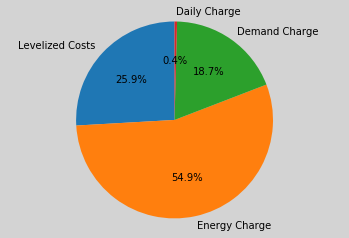

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (130, 235, 150, 6, 21, 31, 0.3, 0.6499999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23584.6


ERROR:ga_logger:total demand cost: 4463.54


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 169,101 kWh
At a cost of $ 0.0758 /kWh
Total Cost of the system: $ 23,585 per year


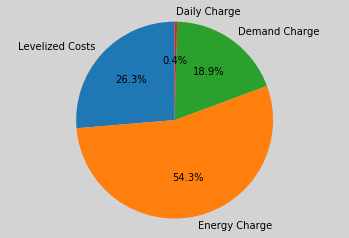

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 145, 120, 11, 56, 6, 0.35, 0.5499999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 11.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 56.0
                                           and a gcr of 0.550


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: invalid value encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:181: RuntimeWarning: divide by zero encountered in true_divide
  vf_pvrow_to_gnd_surf * pvrow_surf_length / gnd_surf_length, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:607: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = np.abs(sum_2 - sum_1) / (2. * width_1)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: divide by zero encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:531: RuntimeWarning: invalid value encountered in true_divide
  vf_1_to_2 = (d1 + d2 - l1 - l2) / (2. * width)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:222: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


/home/user/.local/lib/python3.6/site-packages/pvfactors/viewfactors/vfmethods.py:244: RuntimeWarning: invalid value encountered in true_divide
  vf_i_to_j * length_i / length_j, 0.)


INFO:pvfactors.run:Parallel calculation elapsed time: 7.592712163925171 sec


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 6.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   8s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 68s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 24298.2


ERROR:ga_logger:total demand cost: 4452.123


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,060 kWh
At a cost of $ 0.0782 /kWh
Total Cost of the system: $ 24,298 per year


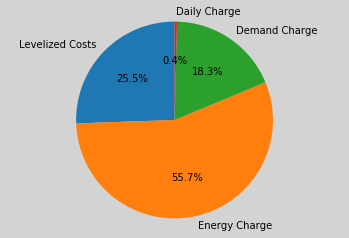

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (120, 245, 125, 41, 56, 16, 0.35, 0.39999999999999997, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 41.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24616.8


ERROR:ga_logger:total demand cost: 4457.5689999999995


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 173,836 kWh
At a cost of $ 0.0797 /kWh
Total Cost of the system: $ 24,617 per year


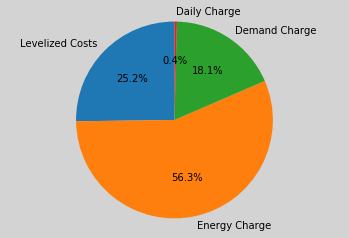

Total roof area of the  building: 4,598 m²
Total roof area used 1,042 m²
Percentage: 22.7%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (245, 105, 245, 46, 11, 6, 0.7, 0.49999999999999994, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24942.6


ERROR:ga_logger:total demand cost: 4452.848


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,305 kWh
At a cost of $ 0.0809 /kWh
Total Cost of the system: $ 24,943 per year


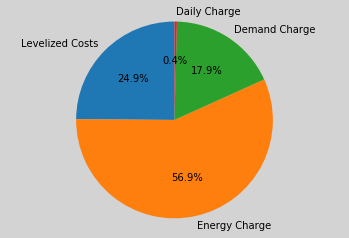

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (250, 260, 230, 56, 16, 21, 0.6499999999999999, 0.5499999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24713.0


ERROR:ga_logger:total demand cost: 4464.229


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 180,333 kWh
At a cost of $ 0.0773 /kWh
Total Cost of the system: $ 24,713 per year


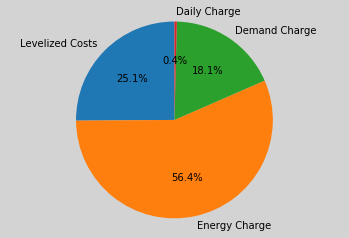

Total roof area of the  building: 4,598 m²
Total roof area used 962 m²
Percentage: 20.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (160, 265, 190, 41, 11, 31, 0.7999999999999998, 0.25, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23441.7


ERROR:ga_logger:total demand cost: 4464.687


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,511 kWh
At a cost of $ 0.0735 /kWh
Total Cost of the system: $ 23,442 per year


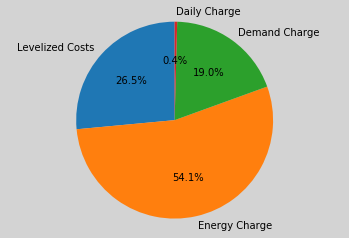

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (180, 210, 115, 21, 46, 56, 0.35, 0.7999999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 47s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23663.8


ERROR:ga_logger:total demand cost: 4458.018


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,916 kWh
At a cost of $ 0.0750 /kWh
Total Cost of the system: $ 23,664 per year


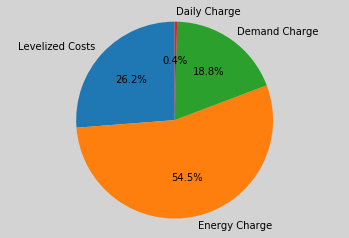

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (260, 145, 240, 51, 16, 1, 0.35, 0.2, 0.7499999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 260
                                           a tilt of 51.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 1.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 61s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24051.6


ERROR:ga_logger:total demand cost: 4453.55


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,402 kWh
At a cost of $ 0.0776 /kWh
Total Cost of the system: $ 24,052 per year


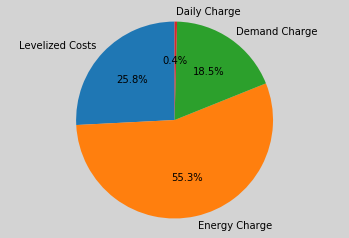

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (115, 235, 245, 1, 56, 6, 0.3, 0.6499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 56.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 67s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24989.6


ERROR:ga_logger:total demand cost: 4450.852


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 178,444 kWh
At a cost of $ 0.0798 /kWh
Total Cost of the system: $ 24,990 per year


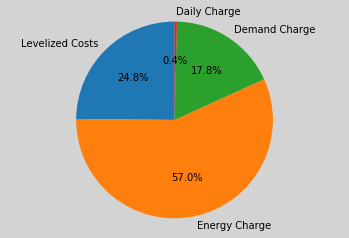

Total roof area of the  building: 4,598 m²
Total roof area used 1,250 m²
Percentage: 27.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (220, 130, 135, 51, 1, 56, 0.8999999999999999, 0.2, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 51.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 56.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24815.4


ERROR:ga_logger:total demand cost: 4490.356


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 175,763 kWh
At a cost of $ 0.0798 /kWh
Total Cost of the system: $ 24,815 per year


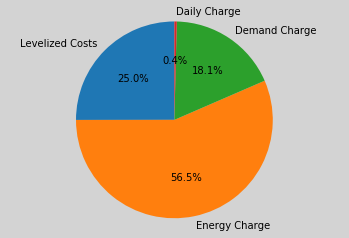

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (120, 220, 210, 51, 56, 36, 0.39999999999999997, 0.7999999999999998, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23816.4


ERROR:ga_logger:total demand cost: 4469.587


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 177,160 kWh
At a cost of $ 0.0736 /kWh
Total Cost of the system: $ 23,816 per year


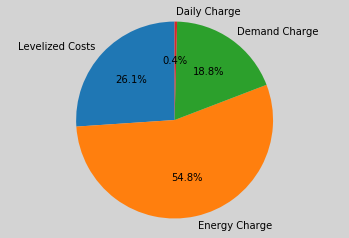

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (95, 255, 220, 26, 1, 31, 0.6499999999999999, 0.8999999999999999, 0.2)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 26.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 1.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 24027.7


ERROR:ga_logger:total demand cost: 4463.841


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 178,721 kWh
At a cost of $ 0.0742 /kWh
Total Cost of the system: $ 24,028 per year


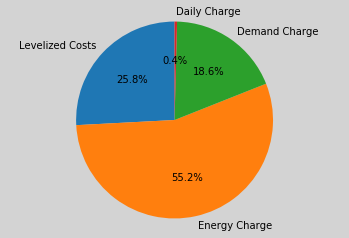

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (165, 225, 205, 31, 26, 46, 0.7499999999999998, 0.3, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.600


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24218.8


ERROR:ga_logger:total demand cost: 4461.376


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 178,999 kWh
At a cost of $ 0.0752 /kWh
Total Cost of the system: $ 24,219 per year


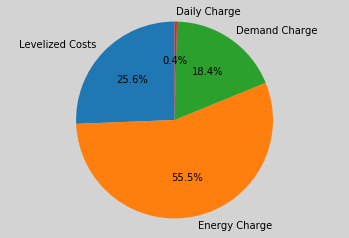

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 235, 130, 56, 46, 46, 0.8999999999999999, 0.7, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 25736.4


ERROR:ga_logger:total demand cost: 4498.043


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 182,057 kWh
At a cost of $ 0.0820 /kWh
Total Cost of the system: $ 25,736 per year


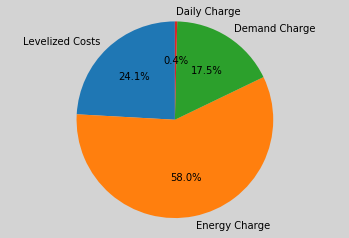

Total roof area of the  building: 4,598 m²
Total roof area used 962 m²
Percentage: 20.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (235, 180, 145, 41, 46, 16, 0.39999999999999997, 0.44999999999999996, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 41.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 145
                                           a tilt of 16.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 23915.0


ERROR:ga_logger:total demand cost: 4488.425


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 174,206 kWh
At a cost of $ 0.0753 /kWh
Total Cost of the system: $ 23,915 per year


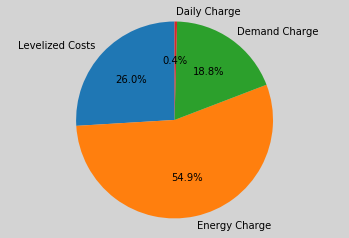

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (215, 215, 130, 36, 21, 41, 0.5499999999999999, 0.6499999999999999, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 215
                                           a tilt of 36.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 41.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 48s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24343.0


ERROR:ga_logger:total demand cost: 4464.194


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 177,498 kWh
At a cost of $ 0.0765 /kWh
Total Cost of the system: $ 24,343 per year


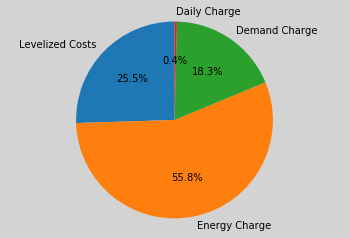

Total roof area of the  building: 4,598 m²
Total roof area used 962 m²
Percentage: 20.9%
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: (150, 210, 260, 36, 16, 31, 0.8999999999999999, 0.5499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 24212.0


ERROR:ga_logger:total demand cost: 4456.94


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 176,140 kWh
At a cost of $ 0.0764 /kWh
Total Cost of the system: $ 24,212 per year


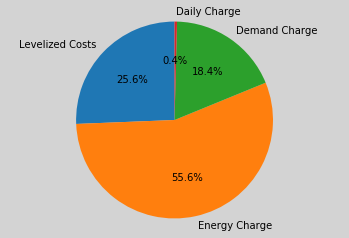

ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 4,598 m²
Total roof area used 1,136 m²
Percentage: 24.7%
20
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      130
azi1      235
azi2      150
tilt0       6
tilt1      21
tilt2      31
gcr0      0.3
gcr1     0.65
gcr2      0.2
Name: 0, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 6.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 21.0
                                           and a gcr of 0.650


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 66s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23584.6


ERROR:ga_logger:total demand cost: 4463.54


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 169,101 kWh
At a cost of $ 0.0758 /kWh
Total Cost of the system: $ 23,585 per year


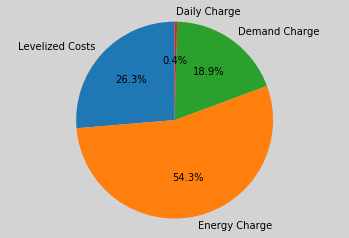

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
[[130, 235, 150, 6, 21, 31, 0.3, 0.6499999999999999, 0.2, 23584.6, 625.0, 0.0, 0.0, 625.0, 1, 'red', {'Levelized Costs': 6207.627899999999, 'Energy Charge': 12815.8676, 'Demand Charge': 4463.54, 'Daily Charge': 97.5645}, 131157.36180890969, 169101.0, 3125.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      265
azi1      190
azi2      125
tilt0      26
tilt1      36
tilt2       1
gcr0      0.6
gcr1     0.25
gcr2      0.2
Name: 1, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 26.0
                                           and a gcr of 0.600


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 1.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 23439.3


ERROR:ga_logger:total demand cost: 4469.49


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 232,811 kWh
At a cost of $ 0.0544 /kWh
Total Cost of the system: $ 23,439 per year


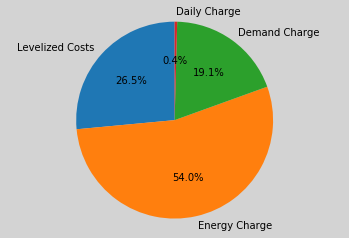

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
[[265, 190, 125, 26, 36, 1, 0.5999999999999999, 0.25, 0.2, 23439.3, 625.0, 0.0, 625.0, 0.0, 1, 'red', {'Levelized Costs': 6207.634499999998, 'Energy Charge': 12664.611, 'Demand Charge': 4469.49, 'Daily Charge': 97.5645}, 132691.46640891937, 232811.0, 2500.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      160
azi1      265
azi2      190
tilt0      41
tilt1      11
tilt2      31
gcr0      0.8
gcr1     0.25
gcr2     0.25
Name: 2, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 11.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 31.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23441.7


ERROR:ga_logger:total demand cost: 4464.687


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,511 kWh
At a cost of $ 0.0735 /kWh
Total Cost of the system: $ 23,442 per year


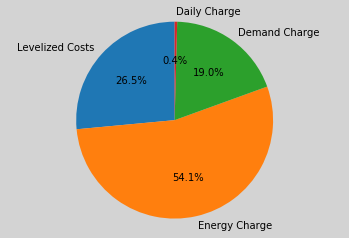

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
[[160, 265, 190, 41, 11, 31, 0.7999999999999998, 0.25, 0.25, 23441.7, 625.0, 0.0, 0.0, 625.0, 1, 'red', {'Levelized Costs': 6207.6628999999975, 'Energy Charge': 12671.785600000003, 'Demand Charge': 4464.687, 'Daily Charge': 97.5645}, 132618.72924945375, 172511.0, 2500.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      180
azi1      195
azi2      165
tilt0      46
tilt1      21
tilt2      31
gcr0      0.7
gcr1     0.85
gcr2     0.35
Name: 3, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23516.2


ERROR:ga_logger:total demand cost: 4466.807


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,380 kWh
At a cost of $ 0.0748 /kWh
Total Cost of the system: $ 23,516 per year


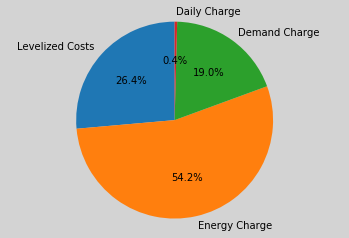

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
[[180, 195, 165, 46, 21, 31, 0.7, 0.8499999999999999, 0.35, 23516.2, 625.0, 0.0, 0.0, 625.0, 1, 'red', {'Levelized Costs': 6207.656099999999, 'Energy Charge': 12744.172400000001, 'Demand Charge': 4466.807, 'Daily Charge': 97.5645}, 131884.51321830007, 170380.0, 1785.71]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      180
azi1      180
azi2      265
tilt0      41
tilt1       6
tilt2      56
gcr0     0.25
gcr1     0.25
gcr2      0.5
Name: 4, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 41.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 6.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 265
                                           a tilt of 56.0
                                           and a gcr of 0.500


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23475.5


ERROR:ga_logger:total demand cost: 4474.722


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,652 kWh
At a cost of $ 0.0740 /kWh
Total Cost of the system: $ 23,476 per year


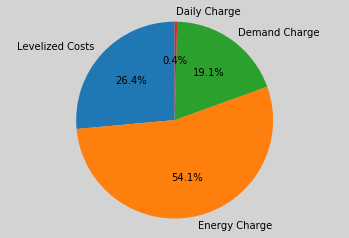

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
[[180, 180, 265, 41, 6, 56, 0.25, 0.25, 0.4999999999999999, 23475.5, 625.0, 625.0, 0.0, 0.0, 1, 'red', {'Levelized Costs': 6207.599100000001, 'Energy Charge': 12695.614399999999, 'Demand Charge': 4474.722, 'Daily Charge': 97.5645}, 132377.00623099995, 171652.0, 2500.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      255
azi1      185
azi2      180
tilt0      26
tilt1      21
tilt2      26
gcr0      0.5
gcr1     0.55
gcr2      0.3
Name: 5, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 52s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23490.6


ERROR:ga_logger:total demand cost: 4461.215


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,422 kWh
At a cost of $ 0.0742 /kWh
Total Cost of the system: $ 23,491 per year


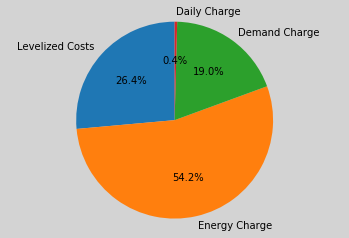

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
[[255, 185, 180, 26, 21, 26, 0.4999999999999999, 0.5499999999999999, 0.3, 23490.6, 625.0, 0.0, 0.0, 625.0, 1, 'red', {'Levelized Costs': 6207.584899999998, 'Energy Charge': 12724.2356, 'Demand Charge': 4461.215, 'Daily Charge': 97.5645}, 132086.78916729998, 171422.0, 2083.33]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      175
azi1      255
azi2      155
tilt0      41
tilt1      26
tilt2      31
gcr0      0.8
gcr1     0.75
gcr2     0.35
Name: 6, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 41.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 255
                                           a tilt of 26.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.350


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23644.7


ERROR:ga_logger:total demand cost: 4466.767


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 169,975 kWh
At a cost of $ 0.0757 /kWh
Total Cost of the system: $ 23,645 per year


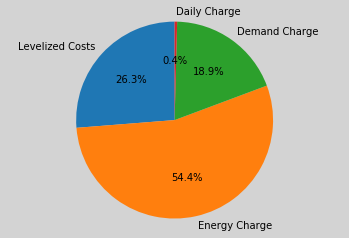

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
[[175, 255, 155, 41, 26, 31, 0.7999999999999998, 0.7499999999999998, 0.35, 23644.7, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.678300000001, 'Energy Charge': 12872.6902, 'Demand Charge': 4466.767, 'Daily Charge': 97.5645}, 130581.1189305502, 169975.0, 1785.71]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      185
azi1      215
azi2      190
tilt0      16
tilt1      21
tilt2      36
gcr0      0.2
gcr1     0.35
gcr2      0.3
Name: 7, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 16.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 102s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 51s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23471.7


ERROR:ga_logger:total demand cost: 4470.813


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,836 kWh
At a cost of $ 0.0735 /kWh
Total Cost of the system: $ 23,472 per year


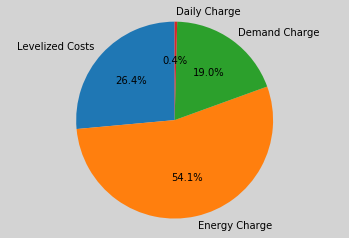

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
[[185, 215, 190, 16, 21, 36, 0.2, 0.35, 0.3, 23471.7, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.5913, 'Energy Charge': 12695.7312, 'Demand Charge': 4470.813, 'Daily Charge': 97.5645}, 132375.8587883849, 172836.0, 2083.33]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      165
azi1      140
azi2      195
tilt0      26
tilt1      51
tilt2      56
gcr0      0.3
gcr1     0.55
gcr2      0.3
Name: 8, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 51.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 195
                                           a tilt of 56.0
                                           and a gcr of 0.300


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23527.1


ERROR:ga_logger:total demand cost: 4461.16


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,561 kWh
At a cost of $ 0.0748 /kWh
Total Cost of the system: $ 23,527 per year


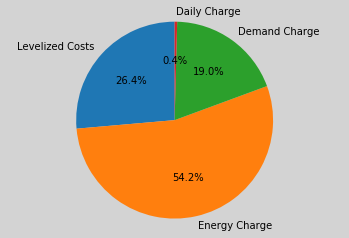

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
[[165, 140, 195, 26, 51, 56, 0.3, 0.5499999999999999, 0.3, 23527.1, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.653399999999, 'Energy Charge': 12760.722099999999, 'Demand Charge': 4461.16, 'Daily Charge': 97.5645}, 131716.6594569998, 170561.0, 2083.33]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      150
azi1      135
azi2      165
tilt0      21
tilt1       6
tilt2      36
gcr0      0.2
gcr1      0.5
gcr2     0.75
Name: 9, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 6.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 36.0
                                           and a gcr of 0.750


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23782.5


ERROR:ga_logger:total demand cost: 4456.231


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,186 kWh
At a cost of $ 0.0765 /kWh
Total Cost of the system: $ 23,782 per year


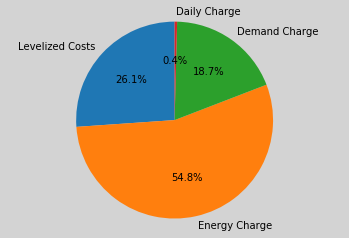

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
[[150, 135, 165, 21, 6, 36, 0.2, 0.4999999999999999, 0.7499999999999998, 23782.5, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.6031, 'Energy Charge': 13021.1014, 'Demand Charge': 4456.231, 'Daily Charge': 97.5645}, 129075.8605386522, 170186.0, 3125.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      235
azi1      180
azi2      170
tilt0      51
tilt1      41
tilt2      56
gcr0     0.75
gcr1      0.3
gcr2      0.7
Name: 10, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 235
                                           a tilt of 51.0
                                           and a gcr of 0.750


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 41.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 56.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 23527.2


ERROR:ga_logger:total demand cost: 4476.312


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,992 kWh
At a cost of $ 0.0741 /kWh
Total Cost of the system: $ 23,527 per year


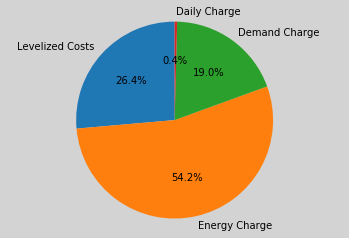

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
[[235, 180, 170, 51, 41, 56, 0.7499999999999998, 0.3, 0.7, 23527.2, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.630799999999, 'Energy Charge': 12745.692700000001, 'Demand Charge': 4476.312, 'Daily Charge': 97.5645}, 131869.19027730013, 171992.0, 2083.33]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      230
azi1      110
azi2      175
tilt0      26
tilt1      21
tilt2      46
gcr0     0.35
gcr1      0.5
gcr2     0.25
Name: 11, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 46.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 65s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23643.9


ERROR:ga_logger:total demand cost: 4480.4


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,697 kWh
At a cost of $ 0.0749 /kWh
Total Cost of the system: $ 23,644 per year


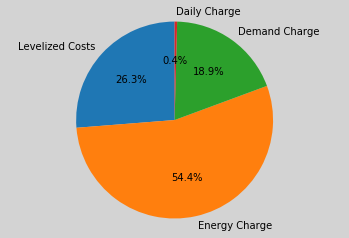

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
[[230, 110, 175, 26, 21, 46, 0.35, 0.4999999999999999, 0.25, 23643.9, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.5823, 'Energy Charge': 12858.353200000001, 'Demand Charge': 4480.4, 'Daily Charge': 97.5645}, 130726.63925140024, 171697.0, 2500.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      180
azi1      155
azi2      180
tilt0      51
tilt1      31
tilt2       1
gcr0      0.4
gcr1     0.45
gcr2     0.55
Name: 12, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 1.0
                                           and a gcr of 0.550


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 23778.8


ERROR:ga_logger:total demand cost: 4469.484


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,019 kWh
At a cost of $ 0.0760 /kWh
Total Cost of the system: $ 23,779 per year


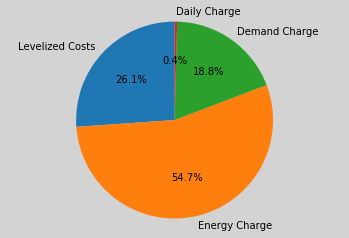

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
[[180, 155, 180, 51, 31, 1, 0.4, 0.45, 0.5499999999999999, 23778.8, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.658699999998, 'Energy Charge': 13004.0928, 'Demand Charge': 4469.484, 'Daily Charge': 97.5645}, 129248.59644467013, 171019.0, 1388.89]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0     140
azi1     110
azi2     125
tilt0     31
tilt1     26
tilt2     21
gcr0     0.3
gcr1     0.9
gcr2     0.7
Name: 13, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 31.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 26.0
                                           and a gcr of 0.900


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 21.0
                                           and a gcr of 0.700


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 62s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23899.4


ERROR:ga_logger:total demand cost: 4465.540999999999


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,236 kWh
At a cost of $ 0.0771 /kWh
Total Cost of the system: $ 23,899 per year


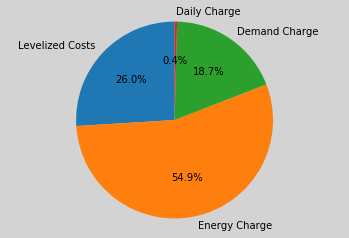

Total roof area of the  building: 4,598 m²
Total roof area used 2,083 m²
Percentage: 45.3%
[[140, 110, 125, 31, 26, 21, 0.3, 0.8999999999999999, 0.7, 23899.4, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.649000000001, 'Energy Charge': 13128.6455, 'Demand Charge': 4465.540999999999, 'Daily Charge': 97.5645}, 127985.22314890001, 170236.0, 2083.33]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      185
azi1      205
azi2      150
tilt0      36
tilt1      46
tilt2      56
gcr0     0.45
gcr1      0.7
gcr2      0.8
Name: 14, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 46.0
                                           and a gcr of 0.700


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 54s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23578.8


ERROR:ga_logger:total demand cost: 4475.519


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,766 kWh
At a cost of $ 0.0741 /kWh
Total Cost of the system: $ 23,579 per year


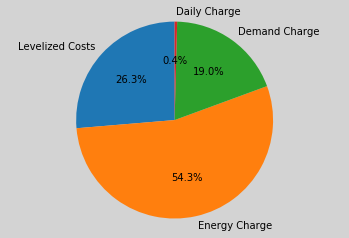

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
[[185, 205, 150, 36, 46, 56, 0.45, 0.7, 0.7999999999999998, 23578.8, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.677299999998, 'Energy Charge': 12798.039200000001, 'Demand Charge': 4475.519, 'Daily Charge': 97.5645}, 131338.03534335134, 172766.0, 1388.89]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      180
azi1      210
azi2      115
tilt0      21
tilt1      46
tilt2      56
gcr0     0.35
gcr1      0.8
gcr2      0.9
Name: 15, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 46s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23663.8


ERROR:ga_logger:total demand cost: 4458.018


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 171,916 kWh
At a cost of $ 0.0750 /kWh
Total Cost of the system: $ 23,664 per year


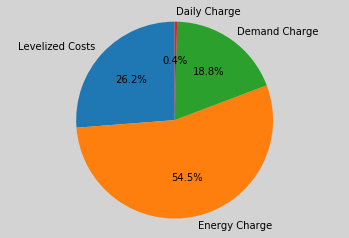

Total roof area of the  building: 4,598 m²
Total roof area used 1,786 m²
Percentage: 38.8%
[[180, 210, 115, 21, 46, 56, 0.35, 0.7999999999999998, 0.8999999999999999, 23663.8, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.6525, 'Energy Charge': 12900.564999999999, 'Demand Charge': 4458.018, 'Daily Charge': 97.5645}, 130298.46121389935, 171916.0, 1785.71]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      250
azi1      260
azi2      150
tilt0      46
tilt1      11
tilt2      21
gcr0     0.85
gcr1     0.55
gcr2      0.2
Name: 16, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 250
                                           a tilt of 46.0
                                           and a gcr of 0.850


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 11.0
                                           and a gcr of 0.550


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 21.0
                                           and a gcr of 0.200


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 101s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 50s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23782.5


ERROR:ga_logger:total demand cost: 4456.231


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,421 kWh
At a cost of $ 0.0764 /kWh
Total Cost of the system: $ 23,782 per year


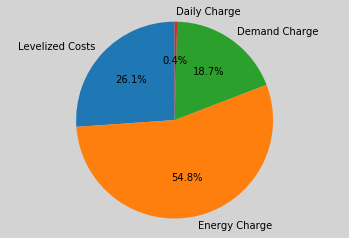

Total roof area of the  building: 4,598 m²
Total roof area used 3,125 m²
Percentage: 68.0%
[[250, 260, 150, 46, 11, 21, 0.8499999999999999, 0.5499999999999999, 0.2, 23782.5, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.617399999999, 'Energy Charge': 13021.0871, 'Demand Charge': 4456.231, 'Daily Charge': 97.5645}, 129075.8605386522, 170421.0, 3125.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      180
azi1      185
azi2      150
tilt0      36
tilt1      51
tilt2      31
gcr0     0.45
gcr1      0.3
gcr2      0.9
Name: 17, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 51.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 55s


ERROR:ga_logger:panel relevance: [625.0, 0.0, 0.0]


ERROR:ga_logger:Cost: 23600.2


ERROR:ga_logger:total demand cost: 4475.493


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 172,411 kWh
At a cost of $ 0.0744 /kWh
Total Cost of the system: $ 23,600 per year


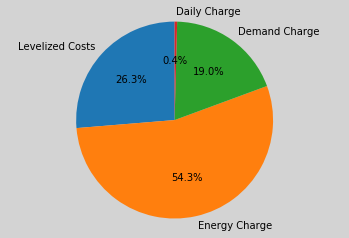

Total roof area of the  building: 4,598 m²
Total roof area used 1,389 m²
Percentage: 30.2%
[[180, 185, 150, 36, 51, 31, 0.45, 0.3, 0.8999999999999999, 23600.2, 625.0, 625.0, 0.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.601200000001, 'Energy Charge': 12819.541299999999, 'Demand Charge': 4475.493, 'Daily Charge': 97.5645}, 131120.01154640006, 172411.0, 1388.89]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      130
azi1      145
azi2      150
tilt0       1
tilt1      21
tilt2      56
gcr0      0.3
gcr1     0.25
gcr2      0.4
Name: 18, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 1.0
                                           and a gcr of 0.300


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 56.0
                                           and a gcr of 0.400


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 100s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 63s


ERROR:ga_logger:panel relevance: [0.0, 625.0, 0.0]


ERROR:ga_logger:Cost: 23876.6


ERROR:ga_logger:total demand cost: 4456.731


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 170,385 kWh
At a cost of $ 0.0770 /kWh
Total Cost of the system: $ 23,877 per year


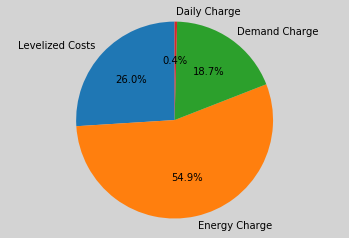

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
[[130, 145, 150, 1, 21, 56, 0.3, 0.25, 0.4, 23876.6, 625.0, 0.0, 625.0, 0.0, 1, 'blue', {'Levelized Costs': 6207.587699999996, 'Energy Charge': 13114.716800000002, 'Demand Charge': 4456.731, 'Daily Charge': 97.5645}, 128126.53519036002, 170385.0, 2500.0]]
The maximum power used is 78 kW
The minimum power used is 6 kW
The average power used is 30 kW
The total Electricity use is 261,136 kWh or 261 MWh
This building is in the **Medium General Service** Rate
The maximum demand charge is: $ 10,626.92


ERROR:ga_logger:panel values: azi0      120
azi1      220
azi2      210
tilt0      51
tilt1      56
tilt2      36
gcr0      0.4
gcr1      0.8
gcr2     0.25
Name: 19, dtype: object


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 51.0
                                           and a gcr of 0.400


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 56.0
                                           and a gcr of 0.800


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 36.0
                                           and a gcr of 0.250


ERROR:ga_logger:Generated the panel irradiance in   0s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in  99s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 70s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 625.0]


ERROR:ga_logger:Cost: 23816.4


ERROR:ga_logger:total demand cost: 4469.587


ERROR:ga_logger:total daily cost: 97.5645


Total Electricity Imported from the grid 177,160 kWh
At a cost of $ 0.0736 /kWh
Total Cost of the system: $ 23,816 per year


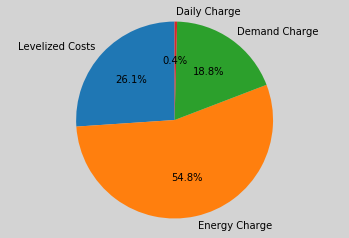

Total roof area of the  building: 4,598 m²
Total roof area used 2,500 m²
Percentage: 54.4%
[[120, 220, 210, 51, 56, 36, 0.4, 0.7999999999999998, 0.25, 23816.4, 625.0, 0.0, 0.0, 625.0, 1, 'blue', {'Levelized Costs': 6207.575700000002, 'Energy Charge': 13041.672799999998, 'Demand Charge': 4469.587, 'Daily Charge': 97.5645}, 128867.35252458374, 177160.0, 2500.0]]


In [25]:
pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_file,
                 ehub_file=ehub_file,
                 res_file=res_file,
                 pvbuilding=pvbuilding,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity)
pvoptimizer.runGA(100,20,"BC","DUAL")
pvoptimizer.processGA(ga_proc)